# Video Classification Training

This notebook creates the Video Network Architecture and trains it for grasp testset1. After training the network weights will be stored in the folder `../dataset/grasp_120x90_testset1_logs`

## Dependencies

`Python 3.5.4` is used for development and following packages are required to run the code provided in the notebook:

`pip install googledrivedownloader`<br>
`pip install matplotlib`<br>
`pip install tensorflow-gpu`<br>
`pip install keras`<br>
`pip install numpy`

In [1]:
!pip install tensorflow==1.15.0
!pip install keras==2.2.4

In [2]:
import pickle, os, csv, time, shutil
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path="/content/drive/MyDrive/Deep-Multi-Sensory-Object-Categorization"

In [5]:
def print_image(image, title):
    """Print the image

    :param image: image pixels in list
    :param title: title as string to be printed on top of the image
    """
    plt.imshow(image)
    plt.title(title)
    plt.colorbar()
    plt.show()

def time_taken(start, end):
    """Human readable time between `start` and `end`

    :param start: time.time()
    :param end: time.time()
    :returns: day:hour:minute:second
    """
    time = end-start
    day = time // (24 * 3600)
    time = time % (24 * 3600)
    hour = time // 3600
    time %= 3600
    minutes = time // 60
    time %= 60
    seconds = time
    day_hour_min_sec = str('%02d' % int(day))+":"+str('%02d' % int(hour))+":"+str('%02d' % int(minutes))+":"+str('%02d' % int(seconds))
    
    return day_hour_min_sec

In [6]:
"""
Downloading `category_object_labels.bin`.
This contains two dictionaries that stores category labels and object labels
"""

# gdd.download_file_from_google_drive(file_id='15xPAbso4-uLk8PcRi9cb70r1r3FaU6ux', dest_path='./dataset/category_object_labels.bin', unzip=False)
bin_file = open(path+"/dataset/category_object_labels.bin", "rb")
category_labels = pickle.load(bin_file)
object_labels = pickle.load(bin_file)
bin_file.close()

## Video Dataset

In [7]:
"""
Downloading testset1 for video of grasp interaction and reading it.
"""

db_file_name = "grasp_120x90_testset1.bin"
gdd.download_file_from_google_drive(file_id='1o8FvoQskCS9rE8Bh4VkUUNMtJgKmDe67',
                                    dest_path=path+'/dataset/'+db_file_name,
                                    unzip=False)

bin_file = open(path+"/dataset/"+db_file_name, "rb")

video_frames_5d_train = pickle.load(bin_file)
category_label_train = pickle.load(bin_file)
object_label_train = pickle.load(bin_file)
category_label_train_one_hot = pickle.load(bin_file)
object_label_train_one_hot = pickle.load(bin_file)

video_frames_5d_test = pickle.load(bin_file)
category_label_test = pickle.load(bin_file)
object_label_test = pickle.load(bin_file)
category_label_test_one_hot = pickle.load(bin_file)
object_label_test_one_hot = pickle.load(bin_file)

bin_file.close()

batch, frames, height, width, channel:  (400, 20, 90, 120, 3)


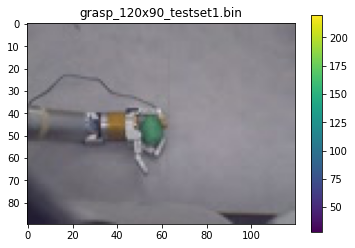

Category:  egg
Object:  egg_rough_styrofoam


In [8]:
"""
Display a frame of the video dataset
"""

batch_no = 188
frame_no = 10

print("batch, frames, height, width, channel: ", video_frames_5d_train.shape)

print_image(video_frames_5d_train[batch_no][frame_no], db_file_name)

print("Category: ", list(category_labels.keys())[list(category_labels.values()).index(category_label_train[batch_no])])
print("Object: ", list(object_labels.keys())[list(object_labels.values()).index(object_label_train[batch_no])])

## Building the Video Network Architecture

<img src="pics/Video_TT_GRU.png" alt="drawing" width="600px"/>

## Video Network Hyper-parameters

The input dimension at each time step is 120 x 90 x 3 = 32,400 which is factorized as 2 x 90 x 90 x 2, the hidden layer is chosen to be 6 x 6 x 6 x 6 = 1,296 and the Tensor-Train ranks are [1, 4, 4, 4, 1].
A fully-connected layer for such a mapping would have required 41,990,400 (32,400 x 1,296) parameters to learn, however the input-to-hidden layer in TT-GRU required only 17,472 parameters.

We applied 0.25 Dropout for both input-to-hidden and hidden-to-hidden mappings in plain GRU as well as its TT modifications; and 0.01 ridge regularization for the single-layered classifier.
The model was deployed in Keras and TensorFlow was used as backend.
We trained for 150 epochs and used the Adam, an gradient-based stochastic optimization algorithm with a learning rate of 1 x $10^{-4}$.

In [9]:
# Network hyper-parameters
batch = 5
training_epochs = 150
display_step = 1

frames = time_step_size = video_frames_5d_train.shape[1]
height = video_frames_5d_train.shape[2]
width = video_frames_5d_train.shape[3]
channel = video_frames_5d_train.shape[4]
num_classes = category_label_train_one_hot.shape[1]

model_path = path+"/dataset/"+db_file_name.split(".")[0]+"_logs/model.ckpt"
logs_path = path+"/dataset/"+db_file_name.split(".")[0]+"_logs/"

X = tf.placeholder('float', [None, None, height, width, channel], name='InputData')
Y = tf.placeholder('float', [None, num_classes], name='LabelData')

In [12]:
import sys
sys.path.append(path)

In [13]:
from TTRNN import TT_GRU, TT_LSTM
from keras.regularizers import l2
from keras.layers import Dense

tt_input_shape = [2, 90, 90, 2]
tt_output_shape = [6, 6, 6, 6]
tt_ranks = [1, 4, 4, 4, 1]
alpha = 1e-2

"""
Functions used to define the Neural Network
"""

def model(data_placeholder):
    with tf.name_scope("Model"):
        XR = tf.reshape(data_placeholder, [batch, frames, height*width*channel])
        rnn_layer = TT_GRU(tt_input_shape=tt_input_shape, tt_output_shape=tt_output_shape,
                               tt_ranks=tt_ranks,
                                return_sequences=False,
                                dropout=0.25, recurrent_dropout=0.25, activation='tanh')
        h = rnn_layer(XR)
        logits = Dense(output_dim=num_classes, activation='softmax', kernel_regularizer=l2(alpha))(h)
    return logits

def loss(prediction, label_placeholder):
    with tf.name_scope('Loss'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=label_placeholder))
        # Create a summary to monitor cost tensor
        cost_scalar = tf.summary.scalar("loss", cost)
    return cost, cost_scalar

def training(prediction, label_placeholder):
    with tf.name_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(cost)
    return train_op

def evaluate(prediction, Y):
    with tf.name_scope('Accuracy'):
        # Test model
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        # Create a summary to monitor accuracy tensor
        accuracy_scalar = tf.summary.scalar("accuracy", accuracy)
    return accuracy, accuracy_scalar

Using TensorFlow backend.


In [14]:
"""
Creating the Neural Network
"""

model_dict = {}

prediction = model(X)
model_dict["Model"] = prediction

cost, cost_scalar = loss(prediction, Y)
model_dict["Loss"] = cost
model_dict["Loss_scalar"] = cost_scalar

train_op = training(prediction, Y)
model_dict["Optimizer"] = train_op

eval_op, accuracy_scalar = evaluate(prediction, Y)
model_dict["Accuracy"] = eval_op
model_dict["Accuracy_scalar"] = accuracy_scalar

print("model_dict: ", model_dict)

# Initializing the variables
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver(max_to_keep=1)



Compression factor = 17472 / 125971200 = 0.00013869836915104405
Compressrion factor = 0.00013869836915104405

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", kernel_regularizer=<keras.reg..., units=20)`


model_dict:  {'Model': <tf.Tensor 'Model/dense_1/Softmax:0' shape=(5, 20) dtype=float32>, 'Loss': <tf.Tensor 'Loss/Mean:0' shape=() dtype=float32>, 'Loss_scalar': <tf.Tensor 'Loss/loss:0' shape=() dtype=string>, 'Optimizer': <tf.Operation 'Optimizer/Adam' type=NoOp>, 'Accuracy': <tf.Tensor 'Accuracy/Mean:0' shape=() dtype=float32>, 'Accuracy_scalar': <tf.Tensor 'Accuracy/accuracy:0' shape=() dtype=string>}


In [15]:
if os.path.exists(logs_path):
    shutil.rmtree(logs_path)
    os.makedirs(logs_path)
else:
    os.makedirs(logs_path)

In [16]:
"""
Writing 'Time', 'Epoch', 'Cost', 'Accuracy' in CSV file
"""

epoch_cost_accuracy = []
epoch_cost_accuracy.append("Time")
epoch_cost_accuracy.append("Epoch")
epoch_cost_accuracy.append("Cost")
epoch_cost_accuracy.append("Accuracy")

with open(logs_path+db_file_name.split(".")[0]+"_data.csv",'w') as f:
    writer = csv.writer(f, lineterminator="\n")
    writer.writerow(epoch_cost_accuracy)

## Training

In [ ]:
# Start Training

start_time = time.time()

with tf.Session() as sess:
    # Initialize variables
    sess.run(init)
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost_list = 0.0
        total_batch = int(len(video_frames_5d_train)/batch)
        
        # Shuffle data
        shuffle_indices = np.arange(len(video_frames_5d_train))
        np.random.shuffle(shuffle_indices)
        
        i = 0
        # Loop over all batches
        for start, end in zip(range(0, len(video_frames_5d_train), batch), range(batch, len(video_frames_5d_train)+1, batch)):
            input_data, label_data = video_frames_5d_train[shuffle_indices][start:end], category_label_train_one_hot[shuffle_indices][start:end]
            _, new_cost, cost_scalar = sess.run([model_dict["Optimizer"], model_dict["Loss"], model_dict["Loss_scalar"]], feed_dict={X: input_data, Y: label_data})
            # Compute average loss
            avg_cost_list += new_cost/total_batch
            summary_writer.add_summary(cost_scalar, epoch * total_batch + i)

            i += 1
            
        save_path = saver.save(sess, model_path, epoch)
         
        # Calculate Accuracy
        avg_accuracy_list = 0.0
        total_batch = int(len(video_frames_5d_test)/batch)
        i = 0
        for start, end in zip(range(0, len(video_frames_5d_test), batch), range(batch, len(video_frames_5d_test)+1, batch)):
            input_data, label_data = video_frames_5d_test[start:end], category_label_test_one_hot[start:end]
            accuracy, accuracy_scalar = sess.run([model_dict["Accuracy"], model_dict["Accuracy_scalar"]], feed_dict={X: input_data, Y: label_data})
            # Compute average accuracy
            avg_accuracy_list += accuracy/total_batch
            summary_writer.add_summary(accuracy_scalar, epoch * total_batch + i)
            
            i += 1
        
        # Printing current epoch accuracy
        epoch_cost_accuracy = []
        epoch_cost_accuracy.append(time_taken(start_time, time.time()))
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), ", Time: ", time_taken(start_time, time.time()))
            a_string = "Cost - "
            epoch_cost_accuracy.append(epoch+1)
            
            a_string += str(avg_cost_list)
            epoch_cost_accuracy.append(str(avg_cost_list))
            
            a_string = a_string[0:-2]+" --> Accuracy - "
            a_string += str(avg_accuracy_list)
            epoch_cost_accuracy.append(str(avg_accuracy_list))
            
            print(a_string)
        
        # Writing current epoch data
        with open(logs_path+db_file_name.split(".")[0]+"_data.csv", 'a') as f: # append to the file created
            writer = csv.writer(f, lineterminator="\n")
            writer.writerow(epoch_cost_accuracy)
    
    print("Optimization Finished!")
    end_time = time.time()
    print("Time taken: day, hour, minutes, seconds->", time_taken(start_time, end_time))

Epoch: 0001 , Time:  00:00:02:38
Cost - 2.97001208364963 --> Accuracy - 0.18000000119209292
